# pyphot - A tool for computing photometry from spectra

This notebook provides a quick introduction to the `pyphot` package.

Full documentation available at https://mfouesneau.github.io/pyphot/

<div class="alert alert-block alert-info">

ℹ️ This notebook is based on **Pyphot version 2.0.0.**

</div>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Handle import for pyphot and path
import sys
try:
    import pyphot
except ImportError:
    sys.path.append('../')
    import pyphot

## Quick Start

Quick start example to access the library and it's content: 
- this example uses the internal (HDF) filter library.
- `f = lib.find('irac')` finds all filter names that relates to IRAC (i.e. the four bands).
- prints information about the first IRAC passband, including zeropoints in various systems.

In [4]:
import pyphot
# get the internal default library of passbands filters
lib = pyphot.get_library()
print("Library contains: ", len(lib), " filters")
# find all filter names that relates to IRAC
# and print some info
f = lib.find('irac')
passbands = lib.load_filters(f)  # or lib[f]
passbands[0].info(show_zeropoints=True)

Library contains:  271  filters
Filter object information:
    name:                 SPITZER_IRAC_36
    detector type:        photon
    wavelength units:     AA
    central wavelength:   35634.293911 Angstrom
    pivot wavelength:     35569.270678 Angstrom
    effective wavelength: 35134.320010 Angstrom
    photon wavelength:    35263.773954 Angstrom
    minimum wavelength:   31310.000000 Angstrom
    maximum wavelength:   39740.000000 Angstrom
    norm:                 3181.966405
    effective width:      6848.829972 Angstrom
    fullwidth half-max:   7430.000000 Angstrom
    definition contains 505 points
    Zeropoints
        Vega: 27.948397 mag,
              6.616697169302651e-12 erg / (Angstrom s cm2),
              279.2354008243633 Jy
              5.5117355961901255 ph / (Angstrom s cm2)
          AB: 25.163323 mag,
              8.603413213872212e-11 erg / (Angstrom s cm2),
              3630.7805477009956 Jy
          ST: 21.100000 mag,
              3.6307805477010028e-

Suppose one has a calibrated spectrum and wants to compute the vega magnitude through the HST WFC3 F110W and F160W passband,
- we use the internal Vega spectrum as example
- we load the WFC3 F110W passband from the internal filter library
- we compute the magnitude using the `get_flux` method of the passband

In [10]:
# We'll use Vega spectrum as example
from pyphot.vega import Vega
vega = Vega()
passbands = lib.load_filters(['HST_WFC3_F110W', 'HST_WFC3_F160W'])
# compute the integrated flux through the filter f
# note that it work on many spectra at once
for f in passbands:
    print(f"Passband: {f.name}")
    fluxes = f.get_flux(vega.wavelength, vega.flux, axis=-1)
    # convert to vega magnitudes
    mags = -2.5 * np.log10(fluxes.value) - f.Vega_zero_mag
    print("- Vega magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))
    mags = -2.5 * np.log10(fluxes.value) - f.AB_zero_mag
    print("-   AB magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))
    mags = -2.5 * np.log10(fluxes.value) - f.ST_zero_mag
    print("-   ST magnitude of Vega in {0:s} is : {1:0.3f} mag".format(f.name, mags))

Passband: HST_WFC3_F110W
/spectrum._v_attrs (AttributeSet), 16 attributes
- Vega magnitude of Vega in HST_WFC3_F110W is : 0.000 mag
-   AB magnitude of Vega in HST_WFC3_F110W is : 0.752 mag
-   ST magnitude of Vega in HST_WFC3_F110W is : 2.373 mag
Passband: HST_WFC3_F160W
- Vega magnitude of Vega in HST_WFC3_F160W is : 0.000 mag
-   AB magnitude of Vega in HST_WFC3_F160W is : 1.256 mag
-   ST magnitude of Vega in HST_WFC3_F160W is : 3.502 mag


<div class="alert alert-warning">

⚠️ **Important** `UnitTypeError: Can only apply 'log10' function to dimensionless quantities`

You may encounter a `UnitTypeError` error if you try to compute `log10` (and other non trivial transformations) directly from quantities with units
In this example, it is unclear what Python needs to do with logarithm of flux in flam (erg/s/cm2/Angstrom). You need to either convert the flux to a dimensionless quantity first, e.g. by dividing by a reference flux (e.g., `f.Vega_zero_flux, f.AB_zero_flux, f.ST_zero_flux`), or take `.value` to work with the float. 

</div>

The following code illustrate how to quickly plot passbands based on the ones we queried above.

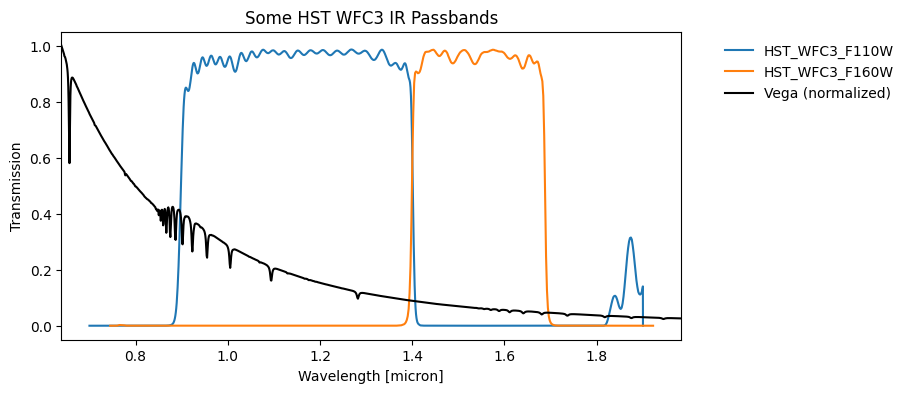

In [28]:
plt.figure(figsize=(8,4))
for f in passbands:
    plt.plot(f.wavelength.to("micron"), f.transmit, label=f.name)
xlim = plt.xlim()
vega_w = vega.wavelength.to("micron")
ind = (vega_w.value >= xlim[0]) & (vega_w.value <= xlim[1])
vega_f = vega.flux.to("flam")[ind]
plt.plot(vega_w[ind], vega_f/vega_f.max(), label='Vega (normalized)', color='k', ls='-')
plt.xlim(xlim)
plt.legend(loc='best', frameon=False, bbox_to_anchor=(1.05, 1))
plt.xlabel("Wavelength [micron]")
plt.ylabel("Transmission")
plt.title("Some HST WFC3 IR Passbands");

## Provided Filter library
This section shows the content of the provided library with respective properties of the passband filters. The code to generate the table is also provided in the documentation.

In [4]:
import pyphot

# define header and table format (as csv)
hdr = ("name", "detector type", "wavelength units",
       "central wavelength", "pivot wavelength", "effective wavelength",
       "Vega mag", "Vega flux", "Vega Jy",
       "AB mag", "AB flux", "AB Jy",
       "ST mag", "ST flux", "ST Jy")
fmt = "{0:s},{1:s},{2:s},{3:.3f},{4:.3f},{5:.3f},{6:.5f},{7:.5g},{8:.5g},{9:.5f},{10:.5g},{11:.5g},{12:.5f},{13:.5g},{14:.5g}\n"

l = pyphot.get_library()

with open('table.csv', 'w') as output:
    output.write(','.join(hdr) + '\n')

    for k in sorted(l.content):
        fk = l[k]
        rec = (fk.name, fk.dtype, fk.wavelength_unit,
               fk.cl.magnitude, fk.lpivot.magnitude, fk.leff.magnitude,
               fk.Vega_zero_mag, fk.Vega_zero_flux.magnitude, fk.Vega_zero_Jy.magnitude,
               fk.AB_zero_mag, fk.AB_zero_flux.magnitude, fk.AB_zero_Jy.magnitude,
               fk.ST_zero_mag, fk.ST_zero_flux.magnitude, fk.ST_zero_Jy.magnitude)
        output.write(fmt.format(*rec)) 

/Users/fouesneau/anaconda/lib/python3.6/site-packages/pyphot/phot.py:144: RuntimeWarning: invalid value encountered in double_scalars
  lpivot2 = self._lT / trapz(self.transmit / self._wavelength, self._wavelength)
/Users/fouesneau/anaconda/lib/python3.6/site-packages/pyphot/phot.py:140: RuntimeWarning: invalid value encountered in double_scalars
  self._cl        = self._lT / self.norm
/Users/fouesneau/anaconda/lib/python3.6/site-packages/pyphot/phot.py:274: RuntimeWarning: invalid value encountered in double_scalars
  leff /= np.trapz(s.transmit * v.flux.magnitude, w, axis=-1)
/Users/fouesneau/anaconda/lib/python3.6/site-packages/pyphot/phot.py:611: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(f_vega)


**Table description**

* name: the identification name of the filter in the library.
* detector type: energy or photon counter.
* wavelength units: filter defined with these units and all wavelength properties: central wavelength, pivot wavelength, and effective wavelength.
* <X> mag: magnitude in Vega, AB or ST system (w.r.t. the detector type)
* <X> flux: flux in $erg/s/cm^2/AA $ in the X system
* <X> Jy: flux in $Jy$ (Jansky) in the X system

In [5]:
import pandas as pd
df = pd.read_csv('./table.csv')
df.head()

,name,detector type,wavelength units,central wavelength,pivot wavelength,effective wavelength,Vega mag,Vega flux,Vega Jy,AB mag,AB flux,AB Jy,ST mag,ST flux,ST Jy
0,2MASS_H,photon,AA,16513.665,16494.947,16386.037,24.86219,1.135300e-10,1030.40,23.49470,4.000500e-10,3630.8,21.1,3.630800e-09,32952.0
1,2MASS_J,photon,AA,12408.376,12390.788,12282.553,23.76734,3.112200e-10,1593.80,22.87344,7.089600e-10,3630.8,21.1,3.630800e-09,18594.0
2,2MASS_Ks,photon,AA,21655.864,21638.169,21521.413,25.92164,4.279000e-11,668.29,24.08405,2.324800e-10,3630.8,21.1,3.630800e-09,56705.0
3,CFHT_CFH12K_CFH7406,photon,AA,4888.664,4888.514,4891.329,20.91453,4.307100e-09,3433.40,20.85383,4.554800e-09,3630.8,21.1,3.630800e-09,2894.2
4,CFHT_CFH12K_CFH7504,photon,AA,5037.756,5037.593,5036.966,20.83347,4.641000e-09,3928.60,20.91906,4.289200e-09,3630.8,21.1,3.630800e-09,3073.4


## Extention to Lick indices

We also include functions to compute lick indices and provide a series of commonly use ones.

The Lick system of spectral line indices is one of the most commonly used methods of determining ages and metallicities of unresolved (integrated light) stellar populations.

In [6]:
# convert to magnitudes
import numpy as np
from pyphot import LickLibrary
from pyphot.vega import Vega

vega = Vega()
# using the internal collection of indices
lib = LickLibrary()
f = lib['CN_1']
# work on many spectra at once
index = f.get(vega.wavelength, vega.flux, axis=-1)
print("The index of Vega in {0:s} is {1:f} {2:s}".format(f.name, index, f.index_unit))

The index of Vega in CN_1 is -0.281614 mag


Similarly, we show the content of the provided library with respective properties of the passband filters. 
The table below is also part of the documentation.

In [7]:
# define header and table format (as csv)
hdr = ("name", "wavelength units", "index units", "min", "max" "min blue", "max blue", "min red", "max red")
fmt = "{0:s},{1:s},{2:s},{3:.3f},{4:.3f},{5:.3f},{6:.5f},{7:.3f},{8:.3f}\n"

l = pyphot.LickLibrary()

with open('licks_table.csv', 'w') as output:
    output.write(','.join(hdr) + '\n')

    for k in sorted(l.content):
        fk = l[k]
        # wavelength have units
        band = fk.band.magnitude
        blue = fk.blue.magnitude
        red = fk.red.magnitude
        rec = (fk.name, fk.wavelength_unit, fk.index_unit, band[0], band[1],
               blue[0], blue[1], red[0], red[1])
        output.write(fmt.format(*rec))

In [8]:
import pandas as pd
df = pd.read_csv('./licks_table.csv')
df.head()

,name,wavelength units,index units,min,maxmin blue,max blue,min red,max red
CN_1,AA,mag,4142.125,4177.125,4080.125,4117.625,4244.125,4284.125
CN_2,AA,mag,4142.125,4177.125,4083.875,4096.375,4244.125,4284.125
Ca1_LB13,AA,ew,8484.000,8513.000,8474.000,8484.000,8563.000,8577.000
Ca2_LB13,AA,ew,8522.000,8562.000,8474.000,8484.000,8563.000,8577.000
Ca3_LB13,AA,ew,8642.000,8682.000,8619.000,8642.000,8700.000,8725.000
